In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
%matplotlib inline
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,low_memory=False,
    header=1
)

# Note the warning about dtypes.

In [3]:

y2015.info() 
# identify objects



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [4]:
desc = y2015.describe(include='all').T
# print (desc)

the dataset has so many columns that I need some routine to analyze 
1. what columns have
   - more than %XX NULLS
   - the same values for XX % 
   - variance < than X % of column value 
   - columns that use huge space
 ---------------------------
 describe; info ? 


In [ ]:
# get all base info for all columns
#profile = pandas_profiling.ProfileReport(y2015)
#profile.to_file(outputfile="y2015_profile.html")
# i've done it once. it takes almost 5 min to run

In [4]:
#Separate  the output first
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']


## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [5]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [4]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [7]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.



## The first full attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [19]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

array([ 0.97881789,  0.9801952 ,  0.98071763,  0.98180998,  0.9502256 ,
        0.97805747,  0.9374243 ,  0.98064547,  0.97976583,  0.98073909])

In [21]:
# get list featues with names 
rfc.fit(X,Y)
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns,  columns=['importance']).sort_values('importance', ascending=False)

C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
# check most importtant
feature_importances.head(10)

,importance
out_prncp_inv,0.280437
out_prncp,0.148670
last_pymnt_d_Jan-2017,0.085411
total_rec_prncp,0.067358
next_pymnt_d_Feb-2017,0.064049
last_pymnt_amnt,0.051283
total_pymnt,0.051166
total_pymnt_inv,0.023899
collection_recovery_fee,0.014126
last_pymnt_d_Oct-2016,0.013165


In [27]:
print(feature_importances[0:9].index.values)

['out_prncp_inv' 'out_prncp' 'last_pymnt_d_Jan-2017' 'total_rec_prncp'
 'next_pymnt_d_Feb-2017' 'last_pymnt_amnt' 'total_pymnt' 'total_pymnt_inv'
 'collection_recovery_fee']


The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Second Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [1]:
# Your code here.
# Task Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.
# First, dive into the data that we have and see which features are most important. 
# 
# You don't have to use pcs use just need to fill nulls. in some cases it is better to fill then to drop. 
#
print ('Loan Status counts')
Y.value_counts()

Loan Status counts


NameError: name 'Y' is not defined

In [6]:
#plt.hist(Y)
#plt.xlabel('Loan status')
#plt.ylabel('Count')
#plt.show()

In [42]:
keep_set=set(feature_importances[0:9].index.values)
# drop all columns  except keep set 
drop_list=list(set(X).difference(keep_set))
print(drop_list)
      

['grade_F', 'issue_d_Jan-2015', 'last_credit_pull_d_Jul-2015', 'title_Vacation', 'purpose_renewable_energy', 'home_ownership_OWN', 'num_il_tl', 'last_credit_pull_d_May-2016', 'application_type_INDIVIDUAL', 'last_pymnt_d_Sep-2016', 'purpose_debt_consolidation', 'purpose_other', 'grade_B', 'emp_length_8 years', 'tot_cur_bal', 'title_considerate', 'total_bc_limit', 'emp_length_1 year', 'loan_amnt', 'grade_C', 'acc_now_delinq', 'title_Student Loan', 'home_ownership_MORTGAGE', 'title_Medical expenses', 'num_bc_tl', 'emp_length_< 1 year', 'total_rec_late_fee', 'recoveries', 'mo_sin_old_rev_tl_op', 'verification_status_Source Verified', 'title_Trying to come back to reality!', 'title_Debt consolidation', 'issue_d_Feb-2015', 'title_Major purchase', 'issue_d_Nov-2015', 'issue_d_Aug-2015', 'purpose_home_improvement', 'last_credit_pull_d_Apr-2016', 'total_il_high_credit_limit', 'num_tl_90g_dpd_24m', 'purpose_medical', 'next_pymnt_d_Jan-2017', 'title_Car financing', 'pub_rec', 'mort_acc', 'pub_rec

In [43]:
z1=X.drop(drop_list, axis=1)

In [44]:
z1.shape

(421095, 9)

In [45]:
z = pd.get_dummies(z1)
z = z.dropna(axis=1)


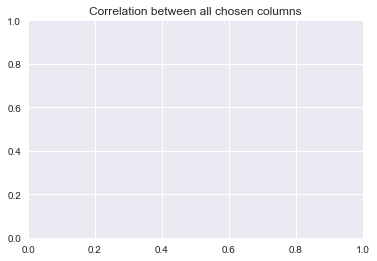

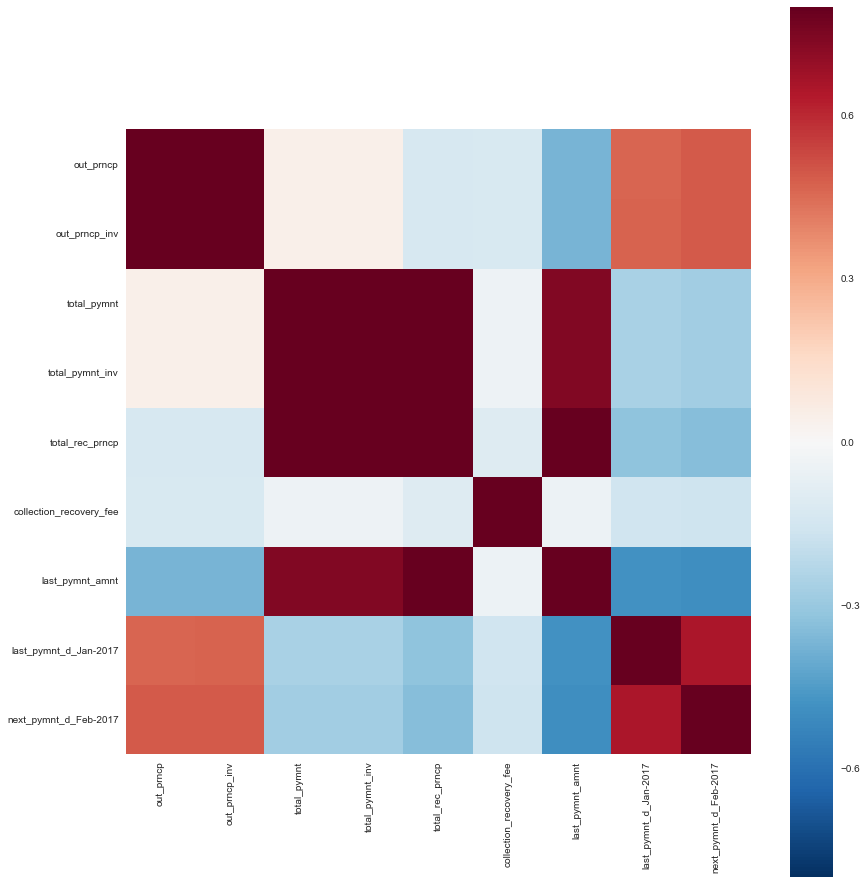

In [46]:
corrmat = z.corr()
plt.title('Correlation between all chosen columns')
plt.figure(figsize=(14, 16))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()



In [51]:
dl=['total_rec_prncp','total_pymnt_inv','out_prncp_inv','out_prncp_inv']


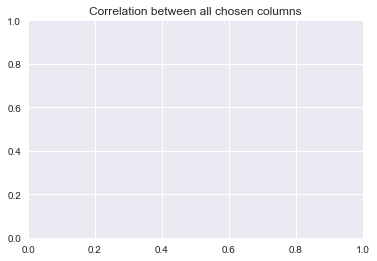

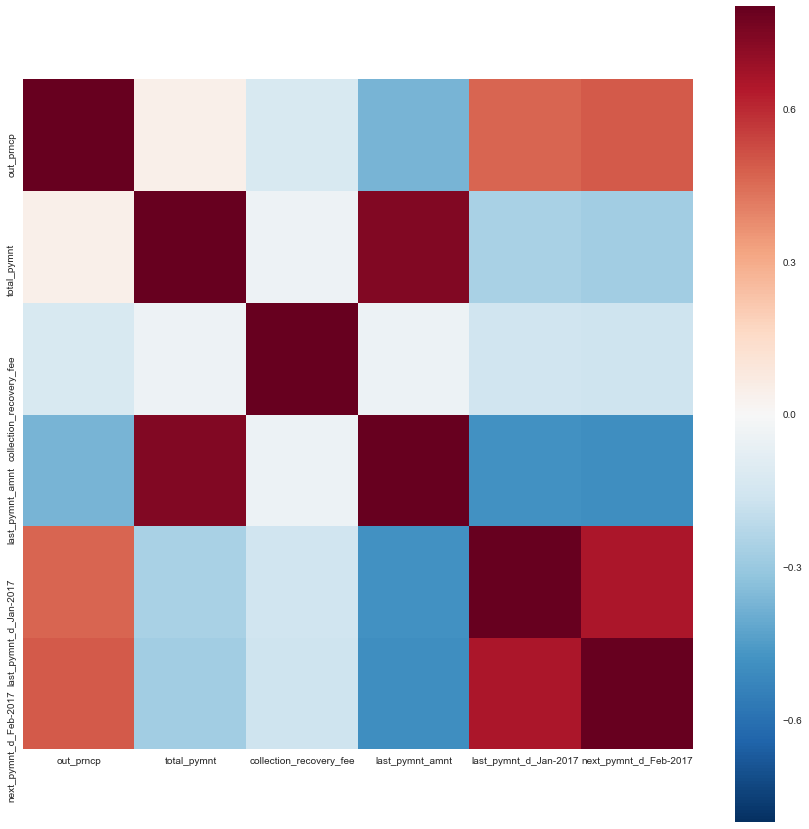

In [54]:
X1=z1.drop(dl, axis=1)
corrmat = X1.corr()
plt.title('Correlation between all chosen columns')
plt.figure(figsize=(15, 15))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [80]:
def RandForestPred(X, Y):
    Xt = pd.get_dummies(X)
    Xt = Xt.dropna(axis=1)
    # split to train test
    
    X_train, X_valid, y_train, y_valid = train_test_split(Xt, Y, test_size=0.2, random_state=10)
    rfc = ensemble.RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_test_pred = rfc.predict(X_train)
    f1_csr = f1_score(y_train, y_test_pred, average='micro')
    print("For columns:" + str(list(Xt)) + "    F1 score for Random forest prediction  on Train data %5.3f" % (f1_csr))
    # validation
    y_valid_pred = rfc.predict(X_valid)
    f1_csr_v = f1_score(y_valid, y_valid_pred, average='micro')
    print("For columns:" + str(list(Xt)) + " F1 score for Random forest prediction on Validation data %5.3f" % (f1_csr) )
    

In [79]:
RandForestPred(X1, Y)


C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


For columns:['out_prncp', 'total_pymnt', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d_Jan-2017', 'next_pymnt_d_Feb-2017']F1 score for Random forest prediction  on Train data 0.993
For columns:['out_prncp', 'total_pymnt', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d_Jan-2017', 'next_pymnt_d_Feb-2017'] F1 score for Random forest prediction on Validation data 0.956


In [81]:
 dl1 = ['last_pymnt_d_Jan-2017', 'next_pymnt_d_Feb-2017','collection_recovery_fee']
 X2 = X1.drop(dl1,axis=1)  

In [82]:
RandForestPred(X2, Y)

C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


For columns:['out_prncp', 'total_pymnt', 'last_pymnt_amnt']    F1 score for Random forest prediction  on Train data 0.987
For columns:['out_prncp', 'total_pymnt', 'last_pymnt_amnt'] F1 score for Random forest prediction on Validation data 0.955


In [83]:
X3=X2.drop(['last_pymnt_amnt'],axis=1)
RandForestPred(X3, Y)

C:\Users\Vadim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


For columns:['out_prncp', 'total_pymnt']    F1 score for Random forest prediction  on Train data 0.980
For columns:['out_prncp', 'total_pymnt'] F1 score for Random forest prediction on Validation data 0.900
